# Andreasen-Huge volatility interpolation tests

In [1]:
import QuantLib as ql
import math as math
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sbn
import sys

# Single Option

In [2]:
dc = ql.Actual365Fixed()
today = ql.Date(4, ql.January, 2018)
rTS = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(0.025)), dc))
qTS = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(0.085)), dc))

calibrationSet = []
strike = 10.0
vol = 0.3
maturity = today + ql.Period(1, ql.Years)
spot = ql.QuoteHandle(ql.SimpleQuote(strike))

calibrationSet = ql.CalibrationSet(
    [ql.CalibrationPair(ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, strike),
                                   ql.EuropeanExercise(maturity)),
                  ql.SimpleQuote(vol))
    ])

interpl = [ql.AndreasenHugeVolatilityInterpl.Linear,
           ql.AndreasenHugeVolatilityInterpl.CubicSpline,
           ql.AndreasenHugeVolatilityInterpl.PiecewiseConstant]

calibrationType = [
    ql.AndreasenHugeVolatilityInterpl.Call,
    ql.AndreasenHugeVolatilityInterpl.Put,
    ql.AndreasenHugeVolatilityInterpl.CallPut
]

for i in range(0, len(interpl)):
    for j in range(0, len(calibrationType)):
        andreasenHugeVolInterplation = ql.AndreasenHugeVolatilityInterpl(
                        calibrationSet, spot, rTS, qTS,
                        interpl[i], calibrationType[j], 50)
        volatilityAdapter = ql.AndreasenHugeVolatilityAdapter(andreasenHugeVolInterplation)
        calculated = volatilityAdapter.blackVol(maturity, strike)
        expected = vol
        if (abs(calculated - expected) > 1e-4):
            print("FAILURE")

# Arbitrage-Freeness

In [3]:
def BorovkovaExampleData():
    dc = ql.Actual365Fixed()
    today = ql.Date(4, ql.January, 2018)
    rTS = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(0.025)), dc))
    qTS = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(0.085)), dc))
    spot = ql.QuoteHandle(ql.SimpleQuote(100))
    b1 = 0.35
    b2 = 0.03
    b3 = 0.005
    b4 = -0.02
    b5 = -0.005
    strikes = [ 35, 50, 75, 100, 125, 150, 200, 300 ]
    maturityMonths = [ 1, 3, 6, 9, 12, 15, 18, 24]
    calibrationSet = []
    for i in range(0, len(strikes)):
        strike = strikes[i]
        for j in range(0, len(maturityMonths)):
            maturityDate = today + ql.Period(maturityMonths[j], ql.Months)
            t = dc.yearFraction(today, maturityDate)
            fwd = spot.value()*qTS.discount(t)/rTS.discount(t)
            mn = math.log(fwd/strike)/math.sqrt(t)
            vol = b1 + b2*mn + b3*mn*mn + b4*t + b5*mn*t
            if (abs(mn) < 3.71*vol):
                calibrationSet+=[ql.CalibrationPair(ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, strike),
                                   ql.EuropeanExercise(maturityDate)),
                                   ql.SimpleQuote(vol))]
    data = [ spot, rTS, qTS, ql.CalibrationSet(calibrationSet)]
    return data

In [4]:
def arbitrageData():
    dc = ql.Actual365Fixed()
    today = ql.Date(4, ql.January, 2018)
    rTS = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(0.025)), dc))
    qTS = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(0.085)), dc))
    spot = ql.QuoteHandle(ql.SimpleQuote(100))
    strikes = [ 100, 100, 100, 150 ]
    maturities = [1, 3, 6, 6]
    vols = [0.25, 0.35, 0.05, 0.35]
    calibrationSet = []
    for i in range(0, len(strikes)):
        strike = strikes[i]
        maturityDate = today + ql.Period(maturities[i], ql.Months)

        vol = vols[i]
        calibrationSet+=[ql.CalibrationPair(ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, strike),
                           ql.EuropeanExercise(maturityDate)),
                           ql.SimpleQuote(vol))]
    data = [ spot, rTS, qTS, ql.CalibrationSet(calibrationSet)]
    return data    
    

In [5]:
data = [BorovkovaExampleData(), arbitrageData()]

In [6]:
for i in range(0, len(data)):
    spot = data[i][0]
    calibrationSet = data[i][3]
    rTS = data[i][1]
    qTS = data[i][2]
    andreasenHugeVolInterplation = ql.AndreasenHugeVolatilityInterpl(calibrationSet, spot, rTS, qTS,
                                                                    ql.AndreasenHugeVolatilityInterpl.CubicSpline,
                                                                    ql.AndreasenHugeVolatilityInterpl.CallPut,
                                                                    5000)
    volatilityAdapter = ql.AndreasenHugeVolatilityAdapter(andreasenHugeVolInterplation)
    for m in np.arange(-0.7, 0.7, 0.05):
        for weeks in range(6, 52):
            maturityDate = today + ql.Period(weeks, ql.Weeks)
            t = dc.yearFraction(today, maturityDate)
            fwd = spot.value()*qTS.discount(t)/rTS.discount(t)
            eps = 0.025
            k  = fwd*math.exp(m)
            km = fwd*math.exp(m - eps)
            kp = fwd*math.exp(m + eps)
            w = volatilityAdapter.blackVariance(t, k, True)
            w_p = volatilityAdapter.blackVariance(t, kp, True)
            w_m = volatilityAdapter.blackVariance(t, km, True)
            w1 = (w_p - w_m)/(2*eps)
            w2 = (w_p + w_m - 2*w)/(eps*eps)
            g_k = math.pow((1-m*w1/(2*w))
                    - w1*w1/4*(1/w + 0.25) + 0.5*w2, 2)
            if (g_k < 0):
                print("FAILURE")
            deltaT = 1.0/365.
            fwdpt = spot.value()*qTS.discount(t+deltaT)/rTS.discount(t+deltaT)
            kpt = fwdpt*math.exp(m)
            w_pt = volatilityAdapter.blackVariance(t+deltaT, kpt, True)
            w_t = (w_pt - w)/deltaT
            if (w_t < -1e-8):
                print("FAILURE")

In [7]:
strikes = [fwd*math.exp(m) for m in np.arange(-0.7, 0.7, 0.05)]
maturities = range(6, 52)
maturityDates = [ today + ql.Period(weeks, ql.Weeks) for weeks in maturities]
vols = [[volatilityAdapter.blackVol(m, s, True) for s in strikes] for m in  maturityDates]

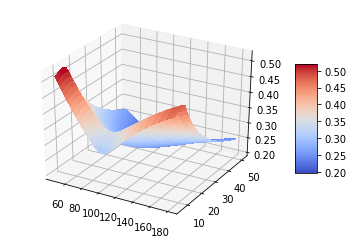

In [8]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  

from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
strikes = np.array([fwd*math.exp(m) for m in np.arange(-0.7, 0.7, 0.05)])
weeks = np.arange(6, 52)
strikes, weeks = np.meshgrid(strikes, weeks)
vol_vect = np.vectorize(lambda s, m: volatilityAdapter.blackVol(m*7/365, s, True))
Z = vol_vect(strikes, weeks)

# Plot the surface.
surf = ax.plot_surface(strikes, weeks, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Peter's and Fabien's SABR Example

In [9]:
def sabrData():
    dc = ql.Actual365Fixed()
    today = ql.Date(4, ql.January, 2018)

    alpha = 0.15
    beta = 0.8
    nu = 0.5
    rho = -0.48
    forward = 0.03
    maturityInYears = 20
    maturityDate = today + ql.Period(maturityInYears, ql.Years)
    maturity = dc.yearFraction(today, maturityDate)
    
    calibrationSet = []
    strikes = [ 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06 ]
    for i in range(0, len(strikes)):
        strike = strikes[i]
        vol = ql.sabrVolatility(
               strike, forward, maturity, alpha, beta, nu, rho)
        calibrationSet+=[ql.CalibrationPair(ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, strike),
                           ql.EuropeanExercise(maturityDate)),
                           ql.SimpleQuote(vol))]
   
    
    rTS = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(forward)), dc))
    qTS = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(forward)), dc))
    spot = ql.QuoteHandle(ql.SimpleQuote(forward))
    
    data = [spot, rTS, qTS, ql.CalibrationSet(calibrationSet)]

    parameter = [alpha, beta, nu, rho, forward, maturity]
    return [data, parameter]


In [10]:
sd = sabrData()
data = sd[0]
parameter = sd[1]

andreasenHugeVolInterplation = ql.AndreasenHugeVolatilityInterpl(data[3], data[0], data[1], data[2])
volAdapter = ql.AndreasenHugeVolatilityAdapter(andreasenHugeVolInterplation)
alpha    = parameter[0]
beta     = parameter[1]
nu       = parameter[2]
rho      = parameter[3]
forward  = parameter[4]
maturity = parameter[5]

for strike in np.arange(0.02, 0.06, 0.001):
    sabrVol = ql.sabrVolatility(
           strike, forward, maturity, alpha, beta, nu, rho)
    ahVol = volAdapter.blackVol(maturity, strike, True)
    tol = 0.0005
    diff = abs(sabrVol - ahVol)
    
    if (not ahVol or diff > 0.005):
        print("FAILURE")

# Different optimizer for Andreasen-Huge

In [11]:
data = sabrData()[0]

optimizationMethods = [
    ql.LevenbergMarquardt(),
    ql.BFGS(),
    ql.Simplex(0.2)
]

for optimizationMethod in optimizationMethods:
    calibError =  ql.AndreasenHugeVolatilityInterpl(
            data[3], data[0], data[1], data[2],
            ql.AndreasenHugeVolatilityInterpl.CubicSpline,
            ql.AndreasenHugeVolatilityInterpl.Call,
            400, ql.nullDouble(), ql.nullDouble(),
            optimizationMethod).calibrationError()
    avgError = calibError.third()
    if (not avgError or avgError > 0.0001):
        print("FAILURE")
   

# Testing that reference date of adapter surface moves along with eval date

In [12]:
today = ql.Date(4, ql.January, 2018)
ql.Settings.instance().evaluationDate = today

dc = ql.Actual365Fixed()
maturity = today + ql.Period(1, ql.Months);

ts = ql.YieldTermStructureHandle(ql.FlatForward(0, ql.NullCalendar(), ql.QuoteHandle(ql.SimpleQuote(0.04)), dc))

s0 = 100.0
impliedVol = 0.2
spot = ql.QuoteHandle(ql.SimpleQuote(s0))

In [13]:
calibrationSet = ql.CalibrationSet([ql.CalibrationPair(ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, s0),
                           ql.EuropeanExercise(maturity)),
                           ql.SimpleQuote(impliedVol))])

In [14]:
andreasenHugeVolInterplation = ql.AndreasenHugeVolatilityInterpl(calibrationSet, spot, ts, ts)

In [15]:
tol = 1e-8

In [16]:
volatilityAdapter = ql.AndreasenHugeVolatilityAdapter(andreasenHugeVolInterplation, tol)

In [17]:
localVolAdapter = ql.AndreasenHugeLocalVolAdapter(andreasenHugeVolInterplation)

In [18]:
volRefDate = volatilityAdapter.referenceDate()

In [19]:
localRefDate = localVolAdapter.referenceDate()

In [20]:
if (volRefDate != today or localRefDate != today):
    print("FAILURE")

In [21]:
modToday = ql.Date(15, ql.January, 2018)

In [22]:
ql.Settings.instance().evaluationDate = modToday

In [23]:
modVolRefDate = volatilityAdapter.referenceDate()
modLocalRefDate = localVolAdapter.referenceDate()

In [24]:
if (modVolRefDate != modToday or modLocalRefDate != modToday):
    print("FAILURE")

In [25]:
modImpliedVol = volatilityAdapter.blackVol(maturity, s0, True)

In [26]:
diff = abs(modImpliedVol - impliedVol)

In [27]:
if (diff > 10*tol):
    print("FAILURE")

# Andreasen-Huge example with Put calibration

In [28]:
def AndreasenHugeExampleData():
    spot = ql.QuoteHandle(ql.SimpleQuote(2772.7))
    maturityTimes = [0.025, 0.101, 0.197, 0.274, 0.523, 0.772,
                  1.769, 2.267, 2.784, 3.781, 4.778, 5.774]
    raw = [
            [ 0.5131, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3366, 0.3291, 0.0000, 0.0000 ],
            [ 0.5864, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3178, 0.3129, 0.3008, 0.0000 ],
            [ 0.6597, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3019, 0.2976, 0.2975, 0.0000 ],
            [ 0.7330, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2863, 0.2848, 0.2848, 0.0000 ],
            [ 0.7697, 0.0000, 0.0000, 0.0000, 0.3262, 0.3079, 0.3001, 0.2843, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 0.8063, 0.0000, 0.0000, 0.0000, 0.3058, 0.2936, 0.2876, 0.2753, 0.2713, 0.2711, 0.2711, 0.2722, 0.2809 ],
            [ 0.8430, 0.0000, 0.0000, 0.0000, 0.2887, 0.2798, 0.2750, 0.2666, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 0.8613, 0.3365, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 0.8796, 0.3216, 0.2906, 0.2764, 0.2717, 0.2663, 0.2637, 0.2575, 0.2555, 0.2580, 0.2585, 0.2611, 0.2693 ],
            [ 0.8979, 0.3043, 0.2797, 0.2672, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 0.9163, 0.2880, 0.2690, 0.2578, 0.2557, 0.2531, 0.2519, 0.2497, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 0.9346, 0.2724, 0.2590, 0.2489, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 0.9529, 0.2586, 0.2488, 0.2405, 0.2407, 0.2404, 0.2411, 0.2418, 0.2410, 0.2448, 0.2469, 0.2501, 0.2584 ],
            [ 0.9712, 0.2466, 0.2390, 0.2329, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 0.9896, 0.2358, 0.2300, 0.2253, 0.2269, 0.2284, 0.2299, 0.2347, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 1.0079, 0.2247, 0.2213, 0.2184, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 1.0262, 0.2159, 0.2140, 0.2123, 0.2142, 0.2173, 0.2198, 0.2283, 0.2275, 0.2322, 0.2384, 0.2392, 0.2486 ],
            [ 1.0445, 0.2091, 0.2076, 0.2069, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 1.0629, 0.2056, 0.2024, 0.2025, 0.2039, 0.2074, 0.2104, 0.2213, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 1.0812, 0.2045, 0.1982, 0.1984, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 1.0995, 0.2025, 0.1959, 0.1944, 0.1962, 0.1988, 0.2022, 0.2151, 0.2161, 0.2219, 0.2269, 0.2305, 0.2399 ],
            [ 1.1178, 0.1933, 0.1929, 0.1920, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 1.1362, 0.0000, 0.0000, 0.0000, 0.1902, 0.1914, 0.1950, 0.2091, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 1.1728, 0.0000, 0.0000, 0.0000, 0.1885, 0.1854, 0.1888, 0.2039, 0.2058, 0.2122, 0.2186, 0.2223, 0.2321 ],
            [ 1.2095, 0.0000, 0.0000, 0.0000, 0.1867, 0.1811, 0.1839, 0.1990, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000 ],
            [ 1.2461, 0.0000, 0.0000, 0.0000, 0.1871, 0.1785, 0.1793, 0.1945, 0.0000, 0.2054, 0.2103, 0.2164, 0.2251 ],
            [ 1.3194, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1988, 0.2054, 0.2105, 0.2190 ],
            [ 1.3927, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1930, 0.2002, 0.2054, 0.2135 ],
            [ 1.4660, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1849, 0.1964, 0.2012, 0.0000 ]
        ]
    
    dc = ql.Actual365Fixed()
    today = ql.Date(1, ql.March, 2010)
    rTS = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(0.0)), dc))
    qTS = ql.YieldTermStructureHandle(ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(0.0)), dc))
    nStrikes = len(raw)
    nMaturities = len(maturityTimes)
    if not nMaturities == len(raw[1])-1:
        print("FAILURE")
    calibrationSet = []
    for i in range(0,len(raw)):
        strike = spot.value()*raw[i][0]
        for j in range(1, len(raw[i])):
            if (raw[i][j] > sys.float_info.epsilon):
                maturity = today + ql.Period(int(365*maturityTimes[j-1]), ql.Days)
                impliedVol = raw[i][j]
                if strike < spot.value():
                    option_type = ql.Option.Put
                else:
                    option_type = ql.Option.Call
                calibrationSet+=[ql.CalibrationPair(ql.VanillaOption(ql.PlainVanillaPayoff(option_type, strike),
                           ql.EuropeanExercise(maturity)),
                           ql.SimpleQuote(impliedVol))]
    data = [spot, rTS, qTS, ql.CalibrationSet(calibrationSet)]
    return data

In [29]:
data = AndreasenHugeExampleData()

In [30]:
expected = [
        ql.AndreasenHugeVolatilityInterpl.Put,
        ql.AndreasenHugeVolatilityInterpl.CubicSpline,
        0.0015, 0.00035,
        0.0020, 0.00035
]

In [39]:
def testAndreasenHugeVolatilityInterpolation(data, expected):
    rTS = data[1]
    qTS = data[2]
    dc = rTS.dayCounter()
    today = rTS.referenceDate()
    ql.Settings.instance().evaluationDate = today
    spot = data[0]
    calibrationSet = data[3]
    
    andreasenHugeVolInterplation = ql.AndreasenHugeVolatilityInterpl(calibrationSet, spot, rTS, qTS,
                    expected[1],
                    expected[0])
    error = andreasenHugeVolInterplation.calibrationError()
    maxError = error.second()
    avgError = error.third()
    
    if (maxError > expected[2] or avgError > expected[3]):
        print("FAILURE")
        
    volatilityAdapter = ql.AndreasenHugeVolatilityAdapter(andreasenHugeVolInterplation)
    localVolAdapter = ql.AndreasenHugeLocalVolAdapter(andreasenHugeVolInterplation)
    localVolProcess = ql.GeneralizedBlackScholesProcess(spot, qTS, rTS,
                                                       ql.BlackVolTermStructureHandle(volatilityAdapter),
                                                       ql.LocalVolTermStructureHandle(localVolAdapter))
    lvAvgError = 0.0
    lvMaxError = 0.0
    n=0
    for i in range(0, len(calibrationSet)):
        option = calibrationSet[i][0]
        payoff = option.payoff()
        payoff = ql.as_plain_vanilla_payoff(payoff)
        strike = payoff.strike()
        optionType = payoff.optionType()
        t = dc.yearFraction(today, option.exercise().lastDate())
        expectedVol = calibrationSet[i][1].value()
        calculatedVol = volatilityAdapter.blackVol(t, strike, True)
        diffVol = abs(expectedVol - calculatedVol)
        tol = max(1e-10, 1.01*maxError)
        if (diffVol > tol):
            print("FAILURE")
            
        fdEngine = ql.FdBlackScholesVanillaEngine(localVolProcess, max(30, int(100*t)),
                    200, 0, ql.FdmSchemeDesc.Douglas(), True)
        
        option.setPricingEngine(fdEngine)
        discount = rTS.discount(t)
        fwd = spot.value()*qTS.discount(t)/discount
        lvImpliedVol = ql.blackFormulaImpliedStdDevLiRS(
                optionType, strike, fwd, option.NPV(),
                discount, 0.0, ql.nullDouble(), 1.0, 1e-12)/math.sqrt(t)
        
        lvError = abs(lvImpliedVol - expectedVol)
        lvMaxError = max(lvError, lvMaxError)
        lvAvgError = (n*lvAvgError + lvError)/(n+1)
        n+=1
    if (lvMaxError > expected[4] or avgError > expected[5]):
        print("FAILURE")

In [40]:
testAndreasenHugeVolatilityInterpolation(data, expected)

# Andreasen-Huge example with Call calibration

In [41]:
data = AndreasenHugeExampleData()

expected = [
        ql.AndreasenHugeVolatilityInterpl.Call,
        ql.AndreasenHugeVolatilityInterpl.CubicSpline,
        0.0015, 0.00035,
        0.0015, 0.00035
]

testAndreasenHugeVolatilityInterpolation(data, expected)

#  Andreasen-Huge example with instantaneous Call and Put calibration

In [42]:
data = AndreasenHugeExampleData()

expected = [
        ql.AndreasenHugeVolatilityInterpl.CallPut,
        ql.AndreasenHugeVolatilityInterpl.CubicSpline,
        0.0015, 0.00035,
        0.0015, 0.00035
]

testAndreasenHugeVolatilityInterpolation(data, expected)

# Andreasen-Huge example with linear interpolation

In [43]:
data = AndreasenHugeExampleData()

expected = [
        ql.AndreasenHugeVolatilityInterpl.CallPut,
        ql.AndreasenHugeVolatilityInterpl.Linear,
        0.0020, 0.00015,
        0.0040, 0.00035
]

testAndreasenHugeVolatilityInterpolation(data, expected)

# Andreasen-Huge example with piecewise constant interpolation

In [44]:
data = AndreasenHugeExampleData()

expected = [
        ql.AndreasenHugeVolatilityInterpl.CallPut,
        ql.AndreasenHugeVolatilityInterpl.PiecewiseConstant,
        0.0025, 0.00025,
        0.0040, 0.00035
]

testAndreasenHugeVolatilityInterpolation(data, expected)

# Barrier option pricing with Andreasen-Huge local volatility surface

In [47]:
# ToDo

# Andreasen-Huge volatility interpolation with time dependent interest rates and dividend yield

In [48]:
# ToDo